In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [6]:
# Problem parameters
sigma_s = 0.5 # Macroscopic cross section for scattering [cm^(-1)] {Play with sigma_s = ln(2) or something}
sigma_t = 1 # Macroscopic total interaction cross section [cm^(-1)] (reciprocal is neutron mean free path (mfp))
q_ext = 3 # External source density rate [TODO: insert units]

# Left- and right-endpoints of domain
a = 0
b = 10

# Number of cells in domain
ncells = 9
# Number of points in domain
npts   = ncells + 1
points = np.linspace(a, b, npts)
dx     = np.abs(points[1] - points[0])

# Auxillary term for calculation clarity in the loops below
aux_term = (sigma_t/2.0)*dx

# BCs
psi_left = 1.5
psi_right = 1.5

# Quadrature order (needs to be EVEN to avoid mu = 0)
m = 16
angles, weights = scipy.special.roots_legendre(m)
# By default, angles go from negative to positive, and we want the opposite
angles = np.flip(angles)

eps = 1e-14

curr_scalar_fluxes = np.full((ncells, ), np.log(2))
new_scalar_fluxes  = np.zeros(curr_scalar_fluxes.shape)
max_scalar_flux_err = np.max(np.abs(new_scalar_fluxes - curr_scalar_fluxes))

while np.any(max_scalar_flux_err >= eps):
    # Iteratively compute source term as we update the scalar fluxes
    curr_source_term = (q_ext + sigma_s*curr_scalar_fluxes)/2.0
    # Reset new scalar fluxes to zero to iteratively update the current scalar fluxes
    new_scalar_fluxes[:] = 0.0
    for d, mu in enumerate(angles):
        abs_mu = np.abs(mu)
        if mu > 0:
            psi_prev = psi_left
        else:
            psi_prev = psi_right
        
        for i in np.arange(ncells):
            psi_d_i_next      = ((abs_mu - aux_term) * psi_prev + curr_source_term[i]*dx)/ \
                                 (abs_mu + aux_term)
            avg_psi           = (psi_d_i_next + psi_prev)/2.0
            new_scalar_fluxes[i] += avg_psi * weights[d]
            # Store new angular flux at current direction and cell interface
            # to update the next angular flux at the next cell interface
            # in the same direction
            psi_prev = psi_d_i_next 
    
    # Re-compute max error and update source term with updated scalar flux
    max_scalar_flux_err = np.max(np.abs(new_scalar_fluxes - curr_scalar_fluxes))
    curr_scalar_fluxes = new_scalar_fluxes

print(curr_scalar_fluxes)

[3.91017459 4.64830646 4.62332481 4.68593281 4.66123171 4.68034355
 4.66817869 4.67677111 4.67083416]


In [ ]:
plt.figure()
plt.plot(np.arange(ncells) + 1, curr_scalar_fluxes, 'o-')
plt.xlabel('Cell number')
plt.ylabel('Scalar flux')
plt.title('Scalar flux in each cell')
plt.show()

In [2]:
#---------------------------------#
#-- ChatGPT optimized code: 
#---------------------------------#

# Problem parameters
sigma_s = 0.5        # Macroscopic cross-section for scattering [cm^(-1)]
sigma_t = 1          # Macroscopic total interaction cross-section [cm^(-1)]
q_ext = 3            # External source density rate

# Left- and right-endpoints of domain
a = 0
b = 10

# Number of cells in domain
ncells = 9
npts = ncells + 1
points = np.linspace(a, b, npts)
dx = np.abs(points[1] - points[0])

# Auxillary term for calculation clarity in the loops below
aux_term = (sigma_t / 2.0) * dx

# Boundary conditions
psi_left = 1.5
psi_right = 1.5

# Quadrature order (needs to be EVEN to avoid mu = 0)
m = 16
angles, weights = scipy.special.roots_legendre(m)
angles = np.flip(angles)  # Reverse angles order to go from positive to negative

eps = 1e-14

# Initial guess for scalar fluxes
curr_scalar_fluxes = np.full((ncells,), np.log(2))
new_scalar_fluxes = np.zeros_like(curr_scalar_fluxes)

# Iterate until convergence
while True:
    # Compute source term
    curr_source_term = (q_ext + sigma_s * curr_scalar_fluxes) / 2.0
    
    # Reset new scalar fluxes to zero for this iteration
    np.copyto(new_scalar_fluxes, 0.0)
    
    for d, mu in enumerate(angles):
        abs_mu = np.abs(mu)
        psi_prev = psi_left if mu > 0 else psi_right
        
        for i in range(ncells):
            psi_d_i_next = ((abs_mu - aux_term) * psi_prev + curr_source_term[i] * dx) / \
                           (abs_mu + aux_term)
            avg_psi = (psi_d_i_next + psi_prev) / 2.0
            new_scalar_fluxes[i] += avg_psi * weights[d]
            psi_prev = psi_d_i_next
    
    # Check convergence
    max_scalar_flux_err = np.max(np.abs(new_scalar_fluxes - curr_scalar_fluxes))
    if max_scalar_flux_err < eps:
        break
    
    # Update the scalar fluxes
    curr_scalar_fluxes[:] = new_scalar_fluxes

# Output the final scalar fluxes
print(curr_scalar_fluxes)

[4.19385823 5.46867345 5.75643555 5.93057366 5.95882774 5.99363279
 5.99117451 6.00091936 5.9974023 ]


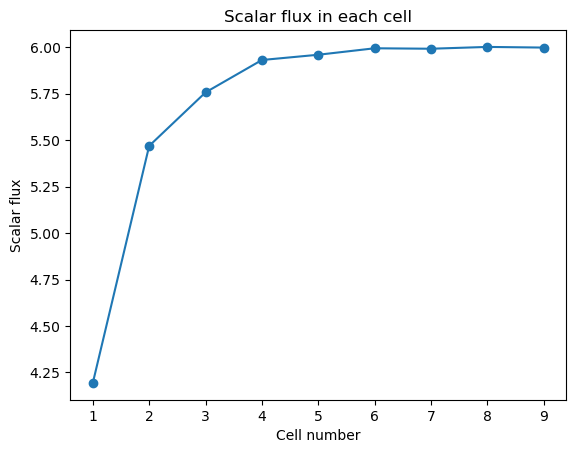

In [5]:
plt.figure()
plt.plot(np.arange(ncells) + 1, curr_scalar_fluxes, 'o-')  
plt.xlabel('Cell number')
plt.ylabel('Scalar flux')
plt.title('Scalar flux in each cell')
plt.show()